# ML CUP 2022 #

## Random Search with Keras #


This notebook creates a neural network using the framework Keras to generalize the problem of the ML cup 2022. it searches the best combination of hyperparameters performing a nested random search over a given range of values. Below there is a brief account about the implementation of the neural network.

hyperparameters considered for the random search:

1. Learning rate
2. The coefficient for momentum
3. Number of units of the hidden layers
4. the lambda coefficient for lasso regularisation (L1)
5. Number of hidden layers (1 against 2)

Model created using early stopping.\
Model selection performed using a cross validation.\
The model assessment phase in not included in this notebook



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers
from keras import metrics

from sklearn.utils import shuffle
from sklearn import model_selection

from operator import itemgetter

import keras.backend as K

2022-12-08 18:39:14.904427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 18:39:15.317621: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 18:39:15.317676: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-08 18:39:16.381370: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

Loading data for the ML cup 2022

In [2]:
# set a fixed seed
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
colnames = ['id', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'target1', 'target2']
mlcup_tr = pd.read_csv("./dataset/ml_cup22/ML-CUP22-TR.csv", sep = ",", names=colnames)
mlcup_tr = mlcup_tr.iloc[1:, :]
mlcup_tr = mlcup_tr.drop('id', axis=1)

In [4]:
x_mlcup_tr = mlcup_tr.iloc[:, 0:9].values
y_mlcup_tr = mlcup_tr.iloc[:, 9:11].values

Below there is the target's shape before the normalization

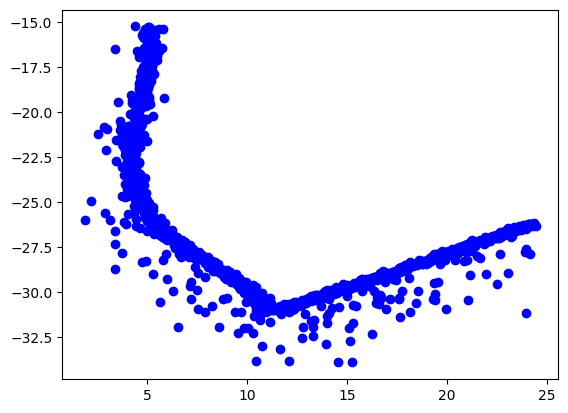

In [5]:
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1], color="blue")
plt.show()

## Data Normalization ##

Let's normalize our data performing a min-max normalization

In [6]:
x_cols = len(x_mlcup_tr[0])

max_col_value_x = [None]*x_cols
max_vl = None

min_col_value_x = [None]*x_cols
min_vl = None

for i in range(x_cols):
    col = x_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    x_mlcup_tr[:, i] = (x_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_x[i] = max_vl
    min_col_value_x[i] = min_vl
    
    
    
y_cols = len(y_mlcup_tr[0])

max_col_value_y = [None]*y_cols

min_col_value_y = [None]*y_cols

for i in range(y_cols):
    col = y_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    y_mlcup_tr[:, i] = (y_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_y[i] = max_vl
    min_col_value_y[i] = min_vl 

Below there is the target shape after the normalization

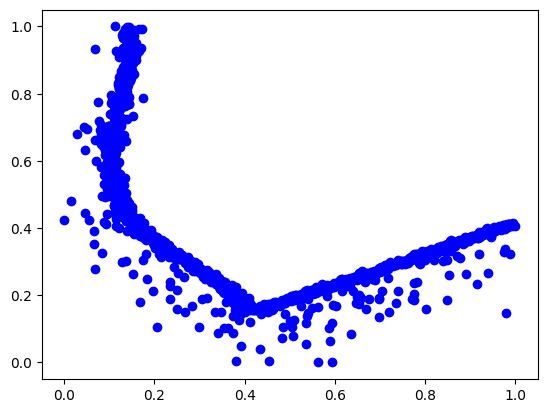

In [7]:
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1], color="blue")
plt.show()

## Neural Network with Random Search ##

Below we extended the RandomSearch class of the keras_tuner library to perform a cross validation during the phase of model selection (which is not supported by the RandomSearch class).

In [8]:
class CrossValidationRandomSearch(kt.RandomSearch):

    
    cross_validation_partitions = -1
    
    
    def __init__(
        self,
        hypermodel=None,
        objective=None,
        max_trials=10,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        folds_number=1,
        **kwargs
    ):
        self.cross_validation_partitions = model_selection.KFold(folds_number)
        
        
        kt.RandomSearch.__init__(
            self,
            hypermodel=hypermodel,
            objective=objective,
            max_trials=max_trials,
            seed=seed,
            hyperparameters=hyperparameters,
            tune_new_entries=tune_new_entries,
            allow_new_entries=allow_new_entries,
            **kwargs
        )

        
    def run_trial(self, trial, x_train, y_train, *args, **kwargs):
    
        histories_cv = []
        histories_folds = []
        # build a different model for each fold of the cross validation
        for train_indices, test_indices in self.cross_validation_partitions.split(x_train):
            x_cv_train, x_cv_val = x_train[train_indices], x_train[test_indices]
            y_cv_train, y_cv_val = y_train[train_indices], y_train[test_indices]
            histories_folds = super(CrossValidationRandomSearch, self).run_trial(
                trial, x_cv_train, y_cv_train, validation_data=(x_cv_val, y_cv_val), *args, **kwargs
            )
            histories_cv.append(histories_folds)

            histories_folds = []
        # return the performance of each model
        return histories_cv

Now we are about to define the mean Euclidean distance to use it as metric for the model.

In [9]:
# This function computes the mean euclidean distance for Keras
def euclidean_distance(y_true, y_pred):
    """
    mean Euclidean distance error
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return (K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))) 

Below we defined two functions; the first one is used to create a model given a combination of hyperparameters, while the second one select a random combination of hyperparameters in a given range

In [10]:
# instantiate a model given a specific combination of hyperparameters
def set_hyperparameters(units, lasso_lambda, learning_rate, momentum, double_layer, my_metric):
    model = Sequential()
    model.add(
        Dense(
            units=units,
            activity_regularizer=regularizers.L1(lasso_lambda),
            activation="relu",
        )
    )
    # if double_layer == True, a second layer for the NN is added
    if (double_layer):
        model.add(
            Dense(
                units=units,
                activity_regularizer=regularizers.L1(lasso_lambda),
                activation="relu"
            )
        )
    model.add(Dense(2, activation="linear", activity_regularizer=regularizers.L2(lasso_lambda)))

    
    # the optimizer is the stochastic gradient descent algorithm
    opt = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    model.compile(
        optimizer=opt, loss="mean_squared_error", metrics=[my_metric]
    )
    
    return model

# extract a random combination of hyperparamaters
def build_regressor(hp, my_metric,min_units=5, max_units=15, min_lasso_lambda=0.00001, max_lasso_lambda=0.01, min_lr_rate=0.05, 
                max_lr_rate=0.15, min_mom=0.0, max_mom=0.8, linear_lr=False, linear_reg=False, double_layer=False):
    
    
    learning_rate_sampling = "log"
    if (linear_lr):
        learning_rate_sampling = "linear"
    
    lasso_lambda_sampling = "log"
    if(linear_reg):
        lasso_lambda_sampling = "linear"
    
    units_step = 1
    if (max_units - min_units > 5):
        units_step = 3
    
    # the variable 'units' represents the number of units of the hidden layer
    # by default this value is extracted between 2 and 11 (the user can specify a different interval)
    units = hp.Int("units", min_value=min_units, max_value=max_units, step=units_step)
    
    # the variable 'lasso_lambda' represents the lambda coefficient for Lasso regularization (L1)
    # by default this value is extracted between 0.0001 and 0.1 with a logarithmic probabilistic law
    # (the user can specify a different interval)
    lasso_lambda = hp.Float(
        "lasso_lambda", min_value=min_lasso_lambda, max_value=max_lasso_lambda, sampling=lasso_lambda_sampling
    )
    
    # the variable 'learning rate' represents the step used by the stochastic gradient descent algorithm
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    learning_rate = hp.Float(
        "learning_rate", min_value=min_lr_rate, max_value=max_lr_rate, sampling=learning_rate_sampling
    )
    
    # the variable 'momentum' represents the coefficient drawn for momentum
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    momentum = hp.Float("momentum", min_value=min_mom, max_value=max_mom, sampling="linear")
    
    # Create the model with the set of hyperparameters drew
    model = set_hyperparameters(
        units=units, lasso_lambda=lasso_lambda, learning_rate=learning_rate, 
        momentum=momentum, double_layer=double_layer, my_metric=my_metric
    )
    return model

the function below was used to denormalize the targets predicted by the final model

In [11]:
def deNormalizer(pred_labels, max_col_value_y, min_col_value_y):
    
    y_cols = len(pred_labels[0])
    
    for i in range(y_cols):
        
        pred_labels[:, i] = pred_labels[:, i] * (max_col_value_y[i] - min_col_value_y[i]) + min_col_value_y[i]
    
    return pred_labels

compute the mean Euclidean error between the target and the predicted label

In [12]:
def compute_mean_euclidean_error(set1, set2):
    
    total_len = set1.shape[0]
    
    eu_dist = [None]*len(set1)
    
    for i in range(total_len):
        diff = set1[i] - set2[i]
        sum = 0
        for j in range(len(diff)):
            sum += math.pow(diff[j], 2)
        eu_dist[i] = math.sqrt(sum)
    
    sum = 0
    for i in range(len(eu_dist)):
        sum += eu_dist[i]
    
    final_vl = sum / len(eu_dist)
    return final_vl

Let's start searching randomly the best combination of hyperparameters using only one hidden layer.

In [13]:
br_l = lambda a : build_regressor(a, my_metric=euclidean_distance)

tuner = CrossValidationRandomSearch( 
    hypermodel=br_l, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts 
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/first/par_hp",
    folds_number=3 # number of folds of the cross validation
)

2022-12-08 18:39:18.581116: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-08 18:39:18.581320: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-08 18:39:18.581349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (carlo-Aspire-A515-52G): /proc/driver/nvidia/version does not exist
2022-12-08 18:39:18.581887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


print a brief description of the search space

In [14]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 15, 'step': 3, 'sampling': None}
lasso_lambda (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.15, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': None, 'sampling': 'linear'}


In [15]:
tuner.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True,
)

Trial 50 Complete [00h 01m 49s]
val_euclidean_distance: 0.09889909128348033

Best val_euclidean_distance So Far: 0.08714301139116287
Total elapsed time: 01h 21m 00s
INFO:tensorflow:Oracle triggered exit


In [16]:
best_hp = tuner.get_best_hyperparameters(3)

print("results of the first random search with a single hidden layer\n")
for i in range(len(best_hp)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp[i].get(h_param))
    print("")

results of the first random search with a single hidden layer

best hyperparameters n. 0
units 11
lasso_lambda 0.004945628857431742
learning_rate 0.05860280995919285
momentum 0.5356385207414234

best hyperparameters n. 1
units 14
lasso_lambda 0.0029337507407488236
learning_rate 0.12331184451567406
momentum 0.40653940341569106

best hyperparameters n. 2
units 11
lasso_lambda 0.006197896114837834
learning_rate 0.1424882191408453
momentum 0.26821652079573194



Brief description of the final neural network's structure

In [17]:
f_model = br_l(best_hp[0])
f_model.build(
input_shape=(None, 9))

f_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 11)                110       
                                                                 
 dense_3 (Dense)             (None, 2)                 24        
                                                                 
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________


In [18]:
tuner.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/single_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 11
lasso_lambda: 0.004945628857431742
learning_rate: 0.05860280995919285
momentum: 0.5356385207414234
Score: 0.08714301139116287
Trial summary
Hyperparameters:
units: 14
lasso_lambda: 0.0029337507407488236
learning_rate: 0.12331184451567406
momentum: 0.40653940341569106
Score: 0.08771392206350963
Trial summary
Hyperparameters:
units: 11
lasso_lambda: 0.006197896114837834
learning_rate: 0.1424882191408453
momentum: 0.26821652079573194
Score: 0.0878418820599715
Trial summary
Hyperparameters:
units: 11
lasso_lambda: 0.0018471232803402432
learning_rate: 0.0706862368876516
momentum: 0.7555983293253434
Score: 0.08794266606370608
Trial summary
Hyperparameters:
units: 14
lasso_lambda: 0.0033243388390995833
learning_rate: 0.07796423464504322
momentum: 0.4208817333636094
Score: 0.08828249449531238
Trial summary
Hyperparameters:
units: 14
lasso_lambda: 0

Now we have found a first best set of hyperparameters. At this point, we are ready to perform a second nested random search to explore the space around the best set of hyperparameters found.

In [19]:
h_param = ["units", "lasso_lambda", "learning_rate", "momentum"]

num_units = best_hp[0].get(h_param[0])
lasso_lambda = best_hp[0].get(h_param[1])
learning_rate = best_hp[0].get(h_param[2])
momentum = best_hp[0].get(h_param[3])
double_layer = False

lasso_lambda_min = (lasso_lambda / 10) * 8
lasso_lambda_max = (lasso_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l2 = lambda a: build_regressor(
    a, my_metric=euclidean_distance,
    min_units=num_units, max_units=num_units, min_lasso_lambda=lasso_lambda_min,
    max_lasso_lambda=lasso_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, 
    linear_lr=True, linear_reg=True, double_layer=double_layer
)

tuner2 = CrossValidationRandomSearch(
    hypermodel=br_l2, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/nested/par_hp",
    folds_number=3 # number of folds of the cross validation
)

Again, below there is a brief summary of the search space

In [20]:
tuner2.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 11, 'max_value': 11, 'step': 1, 'sampling': None}
lasso_lambda (Float)
{'default': 0.003956503085945393, 'conditions': [], 'min_value': 0.003956503085945393, 'max_value': 0.00593475462891809, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.04688224796735428, 'conditions': [], 'min_value': 0.04688224796735428, 'max_value': 0.07032337195103142, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.4285108165931387, 'conditions': [], 'min_value': 0.4285108165931387, 'max_value': 0.6427662248897081, 'step': None, 'sampling': 'linear'}


On the cell below we started the second nested random search (with again only one hidden layer)

In [21]:
tuner2.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 02m 29s]
val_euclidean_distance: 0.08968696370720863

Best val_euclidean_distance So Far: 0.08661475777626038
Total elapsed time: 01h 48m 54s
INFO:tensorflow:Oracle triggered exit


Let's print again the best combination of hyperparameters found during this second nested random search

In [22]:
best_hp2 = tuner2.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp2)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp2[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 11
lasso_lambda 0.0046500478911996
learning_rate 0.06899609356536215
momentum 0.5001467746917524

best hyperparameters n. 1
units 11
lasso_lambda 0.004027317261223651
learning_rate 0.0622583072815508
momentum 0.5527021600633842

best hyperparameters n. 2
units 11
lasso_lambda 0.004605694339055443
learning_rate 0.06898259353042013
momentum 0.5084517940914803



Brief description of the final neural network's structure

In [23]:
br_l2 = lambda a : build_regressor(a, my_metric=euclidean_distance)

f_model2 = br_l2(best_hp2[0])
f_model2.build(
input_shape=(None, 9))

f_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 11)                110       
                                                                 
 dense_3 (Dense)             (None, 2)                 24        
                                                                 
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using only one hidden layer

In [24]:
subset_size = int(0.2 * len(x_mlcup_tr))

index = np.random.choice(len(x_mlcup_tr), subset_size, replace=False)
index = np.sort(index)

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [25]:
n_trials = 10

models = [None]*n_trials

for i in range(n_trials):
    models[i] = br_l2(best_hp2[0])

n_epochs = 1000
hist = [None]*n_trials

for i in range(n_trials):
        hist[i] = models[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
30/30 [==============================] - 1s 7ms/step - loss: 0.1223 - euclidean_distance: 0.3440 - val_loss: 0.0470 - val_euclidean_distance: 0.2139
Epoch 2/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0429 - euclidean_distance: 0.2002 - val_loss: 0.0398 - val_euclidean_distance: 0.1916
Epoch 3/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0371 - euclidean_distance: 0.1820 - val_loss: 0.0356 - val_euclidean_distance: 0.1789
Epoch 4/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0335 - euclidean_distance: 0.1708 - val_loss: 0.0313 - val_euclidean_distance: 0.1643
Epoch 5/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0306 - euclidean_distance: 0.1620 - val_loss: 0.0284 - val_euclidean_distance: 0.1556
Epoch 6/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0280 - euclidean_distance: 0.1544 - val_loss: 0.0258 - val_euclidean_distance: 0.1462
Epoch 7/1000
30/30 [========

30/30 [==============================] - 0s 2ms/step - loss: 0.0135 - euclidean_distance: 0.1097 - val_loss: 0.0126 - val_euclidean_distance: 0.1042
Epoch 52/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0135 - euclidean_distance: 0.1098 - val_loss: 0.0126 - val_euclidean_distance: 0.1042
Epoch 53/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0134 - euclidean_distance: 0.1096 - val_loss: 0.0127 - val_euclidean_distance: 0.1067
Epoch 54/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0134 - euclidean_distance: 0.1095 - val_loss: 0.0125 - val_euclidean_distance: 0.1040
Epoch 55/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0134 - euclidean_distance: 0.1094 - val_loss: 0.0125 - val_euclidean_distance: 0.1037
Epoch 56/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0133 - euclidean_distance: 0.1087 - val_loss: 0.0124 - val_euclidean_distance: 0.1038
Epoch 57/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0118 - euclidean_distance: 0.1018 - val_loss: 0.0114 - val_euclidean_distance: 0.0995
Epoch 102/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0118 - euclidean_distance: 0.1016 - val_loss: 0.0116 - val_euclidean_distance: 0.1000
Epoch 103/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0118 - euclidean_distance: 0.1016 - val_loss: 0.0114 - val_euclidean_distance: 0.1000
Epoch 104/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0118 - euclidean_distance: 0.1020 - val_loss: 0.0115 - val_euclidean_distance: 0.0996
Epoch 105/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0118 - euclidean_distance: 0.1018 - val_loss: 0.0114 - val_euclidean_distance: 0.0999
Epoch 106/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0118 - euclidean_distance: 0.1018 - val_loss: 0.0116 - val_euclidean_distance: 0.1002
Epoch 107/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0108 - euclidean_distance: 0.0960 - val_loss: 0.0107 - val_euclidean_distance: 0.0957
Epoch 152/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0108 - euclidean_distance: 0.0960 - val_loss: 0.0105 - val_euclidean_distance: 0.0951
Epoch 153/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0107 - euclidean_distance: 0.0957 - val_loss: 0.0108 - val_euclidean_distance: 0.0962
Epoch 154/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0108 - euclidean_distance: 0.0961 - val_loss: 0.0106 - val_euclidean_distance: 0.0962
Epoch 155/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0107 - euclidean_distance: 0.0956 - val_loss: 0.0107 - val_euclidean_distance: 0.0954
Epoch 156/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0107 - euclidean_distance: 0.0957 - val_loss: 0.0105 - val_euclidean_distance: 0.0953
Epoch 157/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0190 - euclidean_distance: 0.1319 - val_loss: 0.0180 - val_euclidean_distance: 0.1278
Epoch 13/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0183 - euclidean_distance: 0.1304 - val_loss: 0.0171 - val_euclidean_distance: 0.1247
Epoch 14/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0176 - euclidean_distance: 0.1285 - val_loss: 0.0165 - val_euclidean_distance: 0.1233
Epoch 15/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0170 - euclidean_distance: 0.1265 - val_loss: 0.0158 - val_euclidean_distance: 0.1207
Epoch 16/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0164 - euclidean_distance: 0.1249 - val_loss: 0.0153 - val_euclidean_distance: 0.1192
Epoch 17/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0160 - euclidean_distance: 0.1236 - val_loss: 0.0149 - val_euclidean_distance: 0.1175
Epoch 18/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0123 - euclidean_distance: 0.1040 - val_loss: 0.0120 - val_euclidean_distance: 0.1034
Epoch 63/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0123 - euclidean_distance: 0.1035 - val_loss: 0.0120 - val_euclidean_distance: 0.1030
Epoch 64/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0122 - euclidean_distance: 0.1032 - val_loss: 0.0120 - val_euclidean_distance: 0.1028
Epoch 65/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0122 - euclidean_distance: 0.1031 - val_loss: 0.0119 - val_euclidean_distance: 0.1027
Epoch 66/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0122 - euclidean_distance: 0.1032 - val_loss: 0.0118 - val_euclidean_distance: 0.1025
Epoch 67/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0121 - euclidean_distance: 0.1029 - val_loss: 0.0119 - val_euclidean_distance: 0.1028
Epoch 68/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0109 - euclidean_distance: 0.0958 - val_loss: 0.0108 - val_euclidean_distance: 0.0971
Epoch 113/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0108 - euclidean_distance: 0.0961 - val_loss: 0.0106 - val_euclidean_distance: 0.0962
Epoch 114/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0108 - euclidean_distance: 0.0959 - val_loss: 0.0107 - val_euclidean_distance: 0.0967
Epoch 115/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0108 - euclidean_distance: 0.0956 - val_loss: 0.0107 - val_euclidean_distance: 0.0968
Epoch 116/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0107 - euclidean_distance: 0.0957 - val_loss: 0.0108 - val_euclidean_distance: 0.0971
Epoch 117/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0107 - euclidean_distance: 0.0953 - val_loss: 0.0106 - val_euclidean_distance: 0.0963
Epoch 118/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0926 - val_loss: 0.0106 - val_euclidean_distance: 0.0976
Epoch 163/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0929 - val_loss: 0.0102 - val_euclidean_distance: 0.0946
Epoch 164/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0927 - val_loss: 0.0102 - val_euclidean_distance: 0.0954
Epoch 165/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0932 - val_loss: 0.0101 - val_euclidean_distance: 0.0945
Epoch 166/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0927 - val_loss: 0.0101 - val_euclidean_distance: 0.0949
Epoch 167/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0929 - val_loss: 0.0103 - val_euclidean_distance: 0.0948
Epoch 168/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0098 - euclidean_distance: 0.0909 - val_loss: 0.0100 - val_euclidean_distance: 0.0935
Epoch 213/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0098 - euclidean_distance: 0.0908 - val_loss: 0.0099 - val_euclidean_distance: 0.0936
Epoch 214/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0098 - euclidean_distance: 0.0906 - val_loss: 0.0100 - val_euclidean_distance: 0.0946
Epoch 215/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0098 - euclidean_distance: 0.0912 - val_loss: 0.0099 - val_euclidean_distance: 0.0944
Epoch 216/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0098 - euclidean_distance: 0.0912 - val_loss: 0.0099 - val_euclidean_distance: 0.0932
Epoch 217/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0098 - euclidean_distance: 0.0907 - val_loss: 0.0105 - val_euclidean_distance: 0.0978
Epoch 1/1000
30/30 [===========

30/30 [==============================] - 0s 2ms/step - loss: 0.0130 - euclidean_distance: 0.1027 - val_loss: 0.0123 - val_euclidean_distance: 0.1000
Epoch 46/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0129 - euclidean_distance: 0.1026 - val_loss: 0.0124 - val_euclidean_distance: 0.0997
Epoch 47/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0128 - euclidean_distance: 0.1018 - val_loss: 0.0124 - val_euclidean_distance: 0.0995
Epoch 48/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0128 - euclidean_distance: 0.1015 - val_loss: 0.0123 - val_euclidean_distance: 0.0995
Epoch 49/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0127 - euclidean_distance: 0.1013 - val_loss: 0.0122 - val_euclidean_distance: 0.0991
Epoch 50/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0126 - euclidean_distance: 0.1011 - val_loss: 0.0122 - val_euclidean_distance: 0.0994
Epoch 51/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0110 - euclidean_distance: 0.0936 - val_loss: 0.0112 - val_euclidean_distance: 0.0960
Epoch 96/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0110 - euclidean_distance: 0.0934 - val_loss: 0.0110 - val_euclidean_distance: 0.0952
Epoch 97/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0109 - euclidean_distance: 0.0932 - val_loss: 0.0108 - val_euclidean_distance: 0.0948
Epoch 98/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0109 - euclidean_distance: 0.0929 - val_loss: 0.0110 - val_euclidean_distance: 0.0950
Epoch 99/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0108 - euclidean_distance: 0.0928 - val_loss: 0.0108 - val_euclidean_distance: 0.0950
Epoch 100/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0108 - euclidean_distance: 0.0929 - val_loss: 0.0107 - val_euclidean_distance: 0.0947
Epoch 101/1000
30/30 [=============

30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0894 - val_loss: 0.0103 - val_euclidean_distance: 0.0922
Epoch 146/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0101 - euclidean_distance: 0.0894 - val_loss: 0.0102 - val_euclidean_distance: 0.0917
Epoch 147/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0902 - val_loss: 0.0102 - val_euclidean_distance: 0.0915
Epoch 148/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0101 - euclidean_distance: 0.0896 - val_loss: 0.0103 - val_euclidean_distance: 0.0918
Epoch 149/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0101 - euclidean_distance: 0.0896 - val_loss: 0.0102 - val_euclidean_distance: 0.0925
Epoch 150/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0101 - euclidean_distance: 0.0893 - val_loss: 0.0102 - val_euclidean_distance: 0.0920
Epoch 151/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0315 - euclidean_distance: 0.1661 - val_loss: 0.0317 - val_euclidean_distance: 0.1676
Epoch 7/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0295 - euclidean_distance: 0.1591 - val_loss: 0.0285 - val_euclidean_distance: 0.1574
Epoch 8/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0277 - euclidean_distance: 0.1531 - val_loss: 0.0269 - val_euclidean_distance: 0.1521
Epoch 9/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0264 - euclidean_distance: 0.1495 - val_loss: 0.0259 - val_euclidean_distance: 0.1484
Epoch 10/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0251 - euclidean_distance: 0.1446 - val_loss: 0.0244 - val_euclidean_distance: 0.1443
Epoch 11/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0242 - euclidean_distance: 0.1422 - val_loss: 0.0233 - val_euclidean_distance: 0.1405
Epoch 12/1000
30/30 [==================

30/30 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.1127 - val_loss: 0.0138 - val_euclidean_distance: 0.1099
Epoch 57/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.1127 - val_loss: 0.0138 - val_euclidean_distance: 0.1099
Epoch 58/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.1124 - val_loss: 0.0140 - val_euclidean_distance: 0.1101
Epoch 59/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.1127 - val_loss: 0.0137 - val_euclidean_distance: 0.1088
Epoch 60/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.1116 - val_loss: 0.0137 - val_euclidean_distance: 0.1097
Epoch 61/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.1124 - val_loss: 0.0137 - val_euclidean_distance: 0.1090
Epoch 62/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0131 - euclidean_distance: 0.1061 - val_loss: 0.0128 - val_euclidean_distance: 0.1043
Epoch 107/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0130 - euclidean_distance: 0.1059 - val_loss: 0.0124 - val_euclidean_distance: 0.1028
Epoch 108/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0130 - euclidean_distance: 0.1056 - val_loss: 0.0124 - val_euclidean_distance: 0.1029
Epoch 109/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0130 - euclidean_distance: 0.1057 - val_loss: 0.0124 - val_euclidean_distance: 0.1026
Epoch 110/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0130 - euclidean_distance: 0.1061 - val_loss: 0.0123 - val_euclidean_distance: 0.1027
Epoch 111/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0129 - euclidean_distance: 0.1056 - val_loss: 0.0124 - val_euclidean_distance: 0.1035
Epoch 112/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0123 - euclidean_distance: 0.1032 - val_loss: 0.0117 - val_euclidean_distance: 0.1003
Epoch 157/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0122 - euclidean_distance: 0.1028 - val_loss: 0.0120 - val_euclidean_distance: 0.1018
Epoch 158/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0123 - euclidean_distance: 0.1033 - val_loss: 0.0123 - val_euclidean_distance: 0.1035
Epoch 159/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0122 - euclidean_distance: 0.1027 - val_loss: 0.0122 - val_euclidean_distance: 0.1022
Epoch 160/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0122 - euclidean_distance: 0.1029 - val_loss: 0.0117 - val_euclidean_distance: 0.1012
Epoch 161/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0122 - euclidean_distance: 0.1028 - val_loss: 0.0120 - val_euclidean_distance: 0.1019
Epoch 162/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0118 - euclidean_distance: 0.1008 - val_loss: 0.0116 - val_euclidean_distance: 0.1002
Epoch 207/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0118 - euclidean_distance: 0.1011 - val_loss: 0.0114 - val_euclidean_distance: 0.0991
Epoch 208/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0118 - euclidean_distance: 0.1011 - val_loss: 0.0116 - val_euclidean_distance: 0.1002
Epoch 209/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0118 - euclidean_distance: 0.1012 - val_loss: 0.0120 - val_euclidean_distance: 0.1023
Epoch 210/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0118 - euclidean_distance: 0.1013 - val_loss: 0.0114 - val_euclidean_distance: 0.1010
Epoch 1/1000
30/30 [==============================] - 1s 6ms/step - loss: 0.0975 - euclidean_distance: 0.3483 - val_loss: 0.0397 - val_euclidean_distance: 0.2350
Epoch 2/1000
30/30 [=============

30/30 [==============================] - 0s 2ms/step - loss: 0.0114 - euclidean_distance: 0.1028 - val_loss: 0.0115 - val_euclidean_distance: 0.1028
Epoch 47/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0114 - euclidean_distance: 0.1026 - val_loss: 0.0114 - val_euclidean_distance: 0.1025
Epoch 48/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0114 - euclidean_distance: 0.1026 - val_loss: 0.0114 - val_euclidean_distance: 0.1024
Epoch 49/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0113 - euclidean_distance: 0.1019 - val_loss: 0.0112 - val_euclidean_distance: 0.1019
Epoch 50/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0112 - euclidean_distance: 0.1014 - val_loss: 0.0118 - val_euclidean_distance: 0.1046
Epoch 51/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0113 - euclidean_distance: 0.1017 - val_loss: 0.0113 - val_euclidean_distance: 0.1020
Epoch 52/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0940 - val_loss: 0.0104 - val_euclidean_distance: 0.0962
Epoch 97/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0942 - val_loss: 0.0101 - val_euclidean_distance: 0.0946
Epoch 98/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0939 - val_loss: 0.0104 - val_euclidean_distance: 0.0960
Epoch 99/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0940 - val_loss: 0.0103 - val_euclidean_distance: 0.0957
Epoch 100/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0101 - euclidean_distance: 0.0936 - val_loss: 0.0101 - val_euclidean_distance: 0.0943
Epoch 101/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0101 - euclidean_distance: 0.0934 - val_loss: 0.0101 - val_euclidean_distance: 0.0944
Epoch 102/1000
30/30 [============

30/30 [==============================] - 0s 2ms/step - loss: 0.0466 - euclidean_distance: 0.2117 - val_loss: 0.0434 - val_euclidean_distance: 0.2053
Epoch 3/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0406 - euclidean_distance: 0.1960 - val_loss: 0.0395 - val_euclidean_distance: 0.1945
Epoch 4/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0367 - euclidean_distance: 0.1851 - val_loss: 0.0348 - val_euclidean_distance: 0.1816
Epoch 5/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0337 - euclidean_distance: 0.1777 - val_loss: 0.0319 - val_euclidean_distance: 0.1738
Epoch 6/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0312 - euclidean_distance: 0.1711 - val_loss: 0.0293 - val_euclidean_distance: 0.1661
Epoch 7/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0293 - euclidean_distance: 0.1655 - val_loss: 0.0271 - val_euclidean_distance: 0.1600
Epoch 8/1000
30/30 [=====================

30/30 [==============================] - 0s 2ms/step - loss: 0.0126 - euclidean_distance: 0.1028 - val_loss: 0.0122 - val_euclidean_distance: 0.1017
Epoch 53/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0125 - euclidean_distance: 0.1023 - val_loss: 0.0122 - val_euclidean_distance: 0.1019
Epoch 54/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0124 - euclidean_distance: 0.1018 - val_loss: 0.0122 - val_euclidean_distance: 0.1007
Epoch 55/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0123 - euclidean_distance: 0.1015 - val_loss: 0.0122 - val_euclidean_distance: 0.1006
Epoch 56/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0123 - euclidean_distance: 0.1011 - val_loss: 0.0121 - val_euclidean_distance: 0.1007
Epoch 57/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0122 - euclidean_distance: 0.1013 - val_loss: 0.0121 - val_euclidean_distance: 0.1005
Epoch 58/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0108 - euclidean_distance: 0.0942 - val_loss: 0.0113 - val_euclidean_distance: 0.0972
Epoch 103/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0108 - euclidean_distance: 0.0944 - val_loss: 0.0110 - val_euclidean_distance: 0.0958
Epoch 104/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0109 - euclidean_distance: 0.0949 - val_loss: 0.0110 - val_euclidean_distance: 0.0963
Epoch 105/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0108 - euclidean_distance: 0.0944 - val_loss: 0.0111 - val_euclidean_distance: 0.0972
Epoch 106/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0108 - euclidean_distance: 0.0943 - val_loss: 0.0112 - val_euclidean_distance: 0.0971
Epoch 107/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0108 - euclidean_distance: 0.0942 - val_loss: 0.0109 - val_euclidean_distance: 0.0955
Epoch 108/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0909 - val_loss: 0.0103 - val_euclidean_distance: 0.0932
Epoch 153/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0908 - val_loss: 0.0106 - val_euclidean_distance: 0.0950
Epoch 154/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0911 - val_loss: 0.0103 - val_euclidean_distance: 0.0938
Epoch 155/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0101 - euclidean_distance: 0.0907 - val_loss: 0.0104 - val_euclidean_distance: 0.0940
Epoch 156/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0101 - euclidean_distance: 0.0909 - val_loss: 0.0102 - val_euclidean_distance: 0.0931
Epoch 157/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0101 - euclidean_distance: 0.0905 - val_loss: 0.0102 - val_euclidean_distance: 0.0934
Epoch 158/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0148 - euclidean_distance: 0.1159 - val_loss: 0.0140 - val_euclidean_distance: 0.1082
Epoch 14/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.1149 - val_loss: 0.0137 - val_euclidean_distance: 0.1070
Epoch 15/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.1130 - val_loss: 0.0135 - val_euclidean_distance: 0.1058
Epoch 16/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0142 - euclidean_distance: 0.1124 - val_loss: 0.0134 - val_euclidean_distance: 0.1055
Epoch 17/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.1112 - val_loss: 0.0132 - val_euclidean_distance: 0.1045
Epoch 18/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0138 - euclidean_distance: 0.1109 - val_loss: 0.0132 - val_euclidean_distance: 0.1032
Epoch 19/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0111 - euclidean_distance: 0.0942 - val_loss: 0.0109 - val_euclidean_distance: 0.0912
Epoch 64/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0111 - euclidean_distance: 0.0936 - val_loss: 0.0108 - val_euclidean_distance: 0.0911
Epoch 65/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0110 - euclidean_distance: 0.0931 - val_loss: 0.0108 - val_euclidean_distance: 0.0912
Epoch 66/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0110 - euclidean_distance: 0.0935 - val_loss: 0.0107 - val_euclidean_distance: 0.0912
Epoch 67/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0109 - euclidean_distance: 0.0930 - val_loss: 0.0108 - val_euclidean_distance: 0.0927
Epoch 68/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0110 - euclidean_distance: 0.0935 - val_loss: 0.0107 - val_euclidean_distance: 0.0908
Epoch 69/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0098 - euclidean_distance: 0.0856 - val_loss: 0.0096 - val_euclidean_distance: 0.0865
Epoch 114/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0098 - euclidean_distance: 0.0856 - val_loss: 0.0097 - val_euclidean_distance: 0.0849
Epoch 115/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0097 - euclidean_distance: 0.0856 - val_loss: 0.0096 - val_euclidean_distance: 0.0849
Epoch 116/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0097 - euclidean_distance: 0.0853 - val_loss: 0.0098 - val_euclidean_distance: 0.0854
Epoch 117/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0097 - euclidean_distance: 0.0858 - val_loss: 0.0096 - val_euclidean_distance: 0.0848
Epoch 118/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0097 - euclidean_distance: 0.0852 - val_loss: 0.0095 - val_euclidean_distance: 0.0847
Epoch 119/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0092 - euclidean_distance: 0.0820 - val_loss: 0.0092 - val_euclidean_distance: 0.0830
Epoch 164/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0092 - euclidean_distance: 0.0822 - val_loss: 0.0091 - val_euclidean_distance: 0.0832
Epoch 165/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0093 - euclidean_distance: 0.0826 - val_loss: 0.0091 - val_euclidean_distance: 0.0828
Epoch 166/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0092 - euclidean_distance: 0.0819 - val_loss: 0.0091 - val_euclidean_distance: 0.0833
Epoch 167/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0093 - euclidean_distance: 0.0823 - val_loss: 0.0093 - val_euclidean_distance: 0.0837
Epoch 168/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0092 - euclidean_distance: 0.0819 - val_loss: 0.0091 - val_euclidean_distance: 0.0826
Epoch 169/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0166 - euclidean_distance: 0.1271 - val_loss: 0.0157 - val_euclidean_distance: 0.1227
Epoch 25/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0164 - euclidean_distance: 0.1263 - val_loss: 0.0156 - val_euclidean_distance: 0.1229
Epoch 26/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0163 - euclidean_distance: 0.1257 - val_loss: 0.0155 - val_euclidean_distance: 0.1226
Epoch 27/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0162 - euclidean_distance: 0.1251 - val_loss: 0.0154 - val_euclidean_distance: 0.1210
Epoch 28/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0160 - euclidean_distance: 0.1244 - val_loss: 0.0151 - val_euclidean_distance: 0.1194
Epoch 29/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0159 - euclidean_distance: 0.1231 - val_loss: 0.0150 - val_euclidean_distance: 0.1198
Epoch 30/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0128 - euclidean_distance: 0.1091 - val_loss: 0.0121 - val_euclidean_distance: 0.1048
Epoch 75/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0127 - euclidean_distance: 0.1087 - val_loss: 0.0121 - val_euclidean_distance: 0.1054
Epoch 76/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0127 - euclidean_distance: 0.1088 - val_loss: 0.0120 - val_euclidean_distance: 0.1045
Epoch 77/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0127 - euclidean_distance: 0.1089 - val_loss: 0.0121 - val_euclidean_distance: 0.1045
Epoch 78/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0126 - euclidean_distance: 0.1080 - val_loss: 0.0121 - val_euclidean_distance: 0.1046
Epoch 79/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0125 - euclidean_distance: 0.1076 - val_loss: 0.0120 - val_euclidean_distance: 0.1036
Epoch 80/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0112 - euclidean_distance: 0.1001 - val_loss: 0.0110 - val_euclidean_distance: 0.0995
Epoch 125/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0112 - euclidean_distance: 0.0993 - val_loss: 0.0108 - val_euclidean_distance: 0.0982
Epoch 126/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0111 - euclidean_distance: 0.0995 - val_loss: 0.0110 - val_euclidean_distance: 0.0992
Epoch 127/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0111 - euclidean_distance: 0.0993 - val_loss: 0.0108 - val_euclidean_distance: 0.0977
Epoch 128/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0110 - euclidean_distance: 0.0988 - val_loss: 0.0107 - val_euclidean_distance: 0.0972
Epoch 129/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0111 - euclidean_distance: 0.0993 - val_loss: 0.0108 - val_euclidean_distance: 0.0989
Epoch 130/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0103 - euclidean_distance: 0.0949 - val_loss: 0.0102 - val_euclidean_distance: 0.0961
Epoch 175/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0104 - euclidean_distance: 0.0953 - val_loss: 0.0102 - val_euclidean_distance: 0.0951
Epoch 176/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0103 - euclidean_distance: 0.0951 - val_loss: 0.0102 - val_euclidean_distance: 0.0960
Epoch 177/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0103 - euclidean_distance: 0.0953 - val_loss: 0.0102 - val_euclidean_distance: 0.0966
Epoch 178/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0103 - euclidean_distance: 0.0943 - val_loss: 0.0101 - val_euclidean_distance: 0.0951
Epoch 179/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0103 - euclidean_distance: 0.0946 - val_loss: 0.0100 - val_euclidean_distance: 0.0942
Epoch 180/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0141 - euclidean_distance: 0.1075 - val_loss: 0.0131 - val_euclidean_distance: 0.1055
Epoch 36/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.1066 - val_loss: 0.0132 - val_euclidean_distance: 0.1053
Epoch 37/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0139 - euclidean_distance: 0.1065 - val_loss: 0.0128 - val_euclidean_distance: 0.1041
Epoch 38/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0137 - euclidean_distance: 0.1056 - val_loss: 0.0130 - val_euclidean_distance: 0.1049
Epoch 39/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0136 - euclidean_distance: 0.1055 - val_loss: 0.0128 - val_euclidean_distance: 0.1036
Epoch 40/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0136 - euclidean_distance: 0.1052 - val_loss: 0.0126 - val_euclidean_distance: 0.1032
Epoch 41/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0109 - euclidean_distance: 0.0929 - val_loss: 0.0108 - val_euclidean_distance: 0.0958
Epoch 86/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0109 - euclidean_distance: 0.0930 - val_loss: 0.0109 - val_euclidean_distance: 0.0964
Epoch 87/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0109 - euclidean_distance: 0.0937 - val_loss: 0.0108 - val_euclidean_distance: 0.0967
Epoch 88/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0108 - euclidean_distance: 0.0929 - val_loss: 0.0108 - val_euclidean_distance: 0.0962
Epoch 89/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0107 - euclidean_distance: 0.0927 - val_loss: 0.0109 - val_euclidean_distance: 0.0970
Epoch 90/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0108 - euclidean_distance: 0.0929 - val_loss: 0.0107 - val_euclidean_distance: 0.0955
Epoch 91/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0100 - euclidean_distance: 0.0893 - val_loss: 0.0101 - val_euclidean_distance: 0.0932
Epoch 136/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0100 - euclidean_distance: 0.0890 - val_loss: 0.0103 - val_euclidean_distance: 0.0940
Epoch 137/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0099 - euclidean_distance: 0.0889 - val_loss: 0.0104 - val_euclidean_distance: 0.0946
Epoch 138/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0100 - euclidean_distance: 0.0896 - val_loss: 0.0102 - val_euclidean_distance: 0.0933
Epoch 139/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0099 - euclidean_distance: 0.0889 - val_loss: 0.0104 - val_euclidean_distance: 0.0949
Epoch 140/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0099 - euclidean_distance: 0.0891 - val_loss: 0.0101 - val_euclidean_distance: 0.0936
Epoch 141/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0096 - euclidean_distance: 0.0873 - val_loss: 0.0099 - val_euclidean_distance: 0.0931
Epoch 186/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0096 - euclidean_distance: 0.0879 - val_loss: 0.0098 - val_euclidean_distance: 0.0916
Epoch 187/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0096 - euclidean_distance: 0.0872 - val_loss: 0.0099 - val_euclidean_distance: 0.0917
Epoch 188/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0096 - euclidean_distance: 0.0871 - val_loss: 0.0098 - val_euclidean_distance: 0.0918
Epoch 189/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0096 - euclidean_distance: 0.0875 - val_loss: 0.0099 - val_euclidean_distance: 0.0923
Epoch 190/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0095 - euclidean_distance: 0.0870 - val_loss: 0.0098 - val_euclidean_distance: 0.0922
Epoch 191/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0142 - euclidean_distance: 0.1134 - val_loss: 0.0130 - val_euclidean_distance: 0.1090
Epoch 17/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0140 - euclidean_distance: 0.1122 - val_loss: 0.0130 - val_euclidean_distance: 0.1085
Epoch 18/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0138 - euclidean_distance: 0.1111 - val_loss: 0.0132 - val_euclidean_distance: 0.1085
Epoch 19/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0137 - euclidean_distance: 0.1105 - val_loss: 0.0127 - val_euclidean_distance: 0.1070
Epoch 20/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0136 - euclidean_distance: 0.1096 - val_loss: 0.0126 - val_euclidean_distance: 0.1061
Epoch 21/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0134 - euclidean_distance: 0.1085 - val_loss: 0.0125 - val_euclidean_distance: 0.1065
Epoch 22/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0111 - euclidean_distance: 0.0961 - val_loss: 0.0109 - val_euclidean_distance: 0.0938
Epoch 67/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0111 - euclidean_distance: 0.0953 - val_loss: 0.0110 - val_euclidean_distance: 0.0947
Epoch 68/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0111 - euclidean_distance: 0.0957 - val_loss: 0.0108 - val_euclidean_distance: 0.0942
Epoch 69/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0110 - euclidean_distance: 0.0953 - val_loss: 0.0110 - val_euclidean_distance: 0.0944
Epoch 70/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0110 - euclidean_distance: 0.0951 - val_loss: 0.0107 - val_euclidean_distance: 0.0937
Epoch 71/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0110 - euclidean_distance: 0.0945 - val_loss: 0.0107 - val_euclidean_distance: 0.0937
Epoch 72/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0895 - val_loss: 0.0104 - val_euclidean_distance: 0.0904
Epoch 117/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0894 - val_loss: 0.0104 - val_euclidean_distance: 0.0901
Epoch 118/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0894 - val_loss: 0.0102 - val_euclidean_distance: 0.0895
Epoch 119/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0101 - euclidean_distance: 0.0886 - val_loss: 0.0100 - val_euclidean_distance: 0.0892
Epoch 120/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.0889 - val_loss: 0.0102 - val_euclidean_distance: 0.0893
Epoch 121/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0101 - euclidean_distance: 0.0893 - val_loss: 0.0100 - val_euclidean_distance: 0.0887
Epoch 122/1000
30/30 [=========

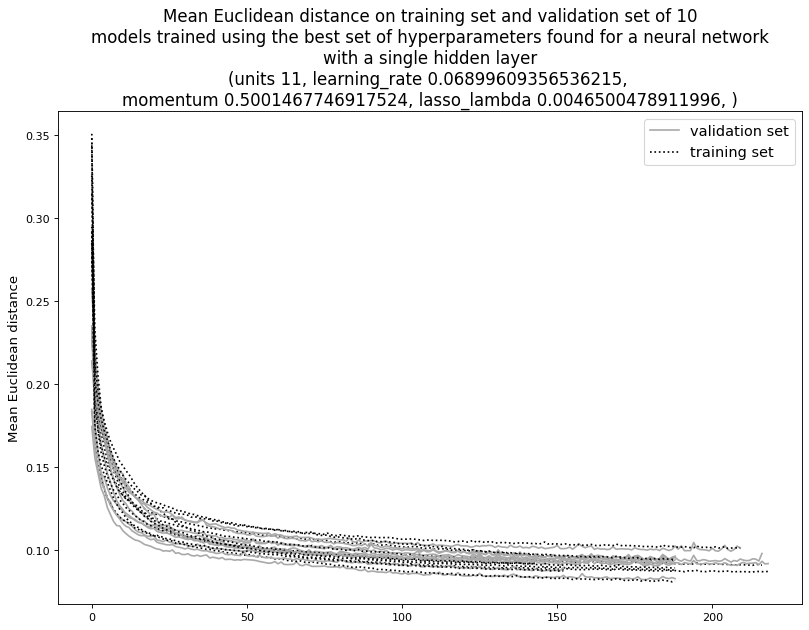

In [26]:
total_hp = 4
labels = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "lasso_lambda"]:
    labels += h_param + " " + str(best_hp2[0].get(h_param)) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_euclidean_distance']
    list_values_tr[i] = hist[i].history['euclidean_distance']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean Euclidean distance on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")", size=15
)

plt.ylabel("Mean Euclidean distance", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/med_single_layer.png")
plt.show()

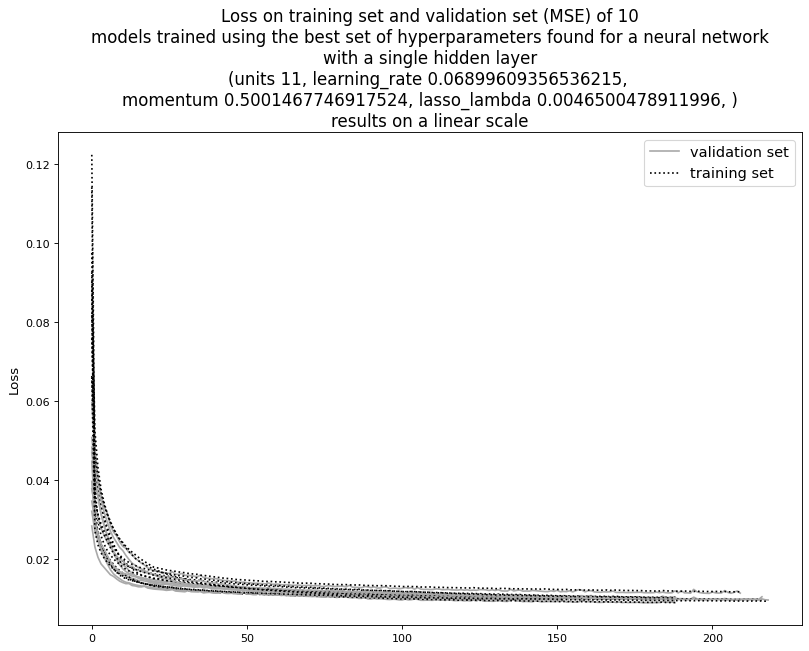

In [27]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist[i].history['val_loss']
    list_values2_tr[i] = hist[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set (MSE) of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer.png")
plt.show()

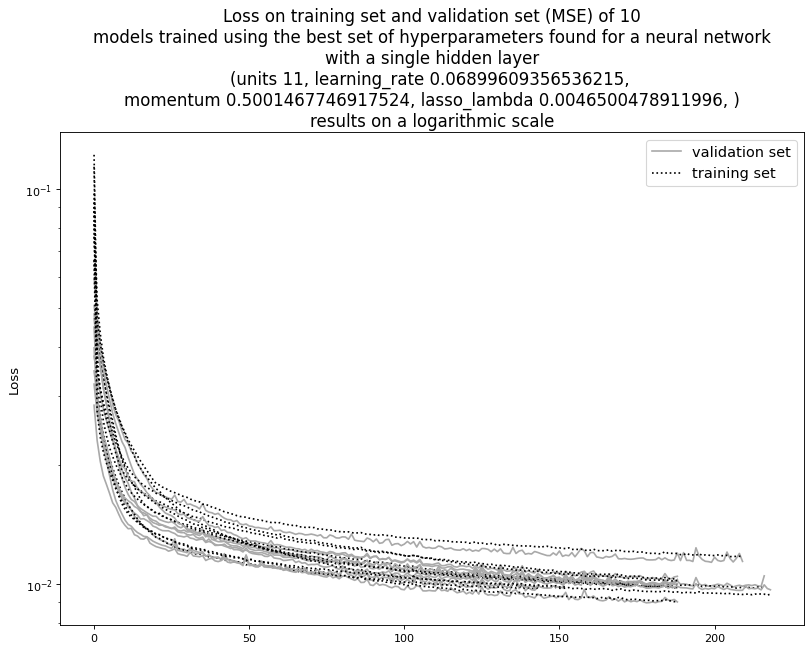

In [28]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set (MSE) of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer_log.png")
plt.yscale('log')
plt.show()

At this point we tried to add a second hidden layer to study whether its presence could help the neural network to generalise the problem.

Therefore we restarted the random search from scratch

In [29]:
# Restore the original training set
x_mlcup_tr = x_mlcup_ds
y_mlcup_tr = y_mlcup_ds

num_units_min = 4
num_units_max = 8
double_layer = True


# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l = lambda a: build_regressor(
    a, my_metric=euclidean_distance, min_units=num_units_min,
    max_units=num_units_max, double_layer=double_layer
)


tuner3 = CrossValidationRandomSearch(
    hypermodel=br_l, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/first/par_hp",
    folds_number=3 # number of folds of the cross validation
)

print a brief description of the search space

In [30]:
tuner3.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 8, 'step': 1, 'sampling': None}
lasso_lambda (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.15, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': None, 'sampling': 'linear'}


In [31]:
tuner3.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 03m 10s]
val_euclidean_distance: 0.10739642381668091

Best val_euclidean_distance So Far: 0.08683207879463832
Total elapsed time: 01h 23m 34s
INFO:tensorflow:Oracle triggered exit


In [32]:
best_hp3 = tuner3.get_best_hyperparameters(3)

print("results of the first random search with a double hidden layer\n")
for i in range(len(best_hp3)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp3[i].get(h_param))
    print("")

results of the first random search with a double hidden layer

best hyperparameters n. 0
units 8
lasso_lambda 0.0007504982996272112
learning_rate 0.11763571488452669
momentum 0.14667727059412725

best hyperparameters n. 1
units 7
lasso_lambda 0.00012774362567517927
learning_rate 0.13097333133448175
momentum 0.6142238144839167

best hyperparameters n. 2
units 7
lasso_lambda 0.0005760531830477185
learning_rate 0.08318457811300017
momentum 0.6031407314302409



Brief description of the final neural network's structure

In [33]:
br_l = lambda a: build_regressor(
    a, my_metric=euclidean_distance, double_layer=True
)

f_model3 = br_l(best_hp3[0])
f_model3.build(
input_shape=(None, 9))

f_model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 80        
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________


In [34]:
tuner3.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/double_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 8
lasso_lambda: 0.0007504982996272112
learning_rate: 0.11763571488452669
momentum: 0.14667727059412725
Score: 0.08683207879463832
Trial summary
Hyperparameters:
units: 7
lasso_lambda: 0.00012774362567517927
learning_rate: 0.13097333133448175
momentum: 0.6142238144839167
Score: 0.08700455476840337
Trial summary
Hyperparameters:
units: 7
lasso_lambda: 0.0005760531830477185
learning_rate: 0.08318457811300017
momentum: 0.6031407314302409
Score: 0.08701336880524953
Trial summary
Hyperparameters:
units: 6
lasso_lambda: 0.0008445792991942714
learning_rate: 0.10344089466505123
momentum: 0.17778771135780885
Score: 0.08788307880361874
Trial summary
Hyperparameters:
units: 6
lasso_lambda: 0.000129774025222921
learning_rate: 0.12765142468923915
momentum: 0.5845781392320665
Score: 0.08794357627630234
Trial summary
Hyperparameters:
units: 7
lasso_lambda: 0.

Again, by now we have found a first best set of hyperparameters. We want to refine them by performing a second nested random search around this best combination of hyperparameters.

In [35]:
h_param = ["units", "lasso_lambda", "learning_rate", "momentum"]

num_units = best_hp3[0].get(h_param[0])
lasso_lambda = best_hp3[0].get(h_param[1])
learning_rate = best_hp3[0].get(h_param[2])
momentum = best_hp3[0].get(h_param[3])
double_layer = True

lasso_lambda_min = (lasso_lambda / 10) * 8
lasso_lambda_max = (lasso_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l2 = lambda a: build_regressor(
    a, my_metric=euclidean_distance, 
    min_units=num_units, max_units=num_units, min_lasso_lambda=lasso_lambda_min,
    max_lasso_lambda=lasso_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, linear_lr=True,
    linear_reg=True, double_layer=double_layer
)

tuner4 = CrossValidationRandomSearch(
    hypermodel=br_l2, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/nested/par_hp",
    folds_number=3
)

Again, below there is a brief summary of the search space

In [36]:
tuner4.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 8, 'step': 1, 'sampling': None}
lasso_lambda (Float)
{'default': 0.000600398639701769, 'conditions': [], 'min_value': 0.000600398639701769, 'max_value': 0.0009005979595526535, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.09410857190762136, 'conditions': [], 'min_value': 0.09410857190762136, 'max_value': 0.14116285786143204, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.1173418164753018, 'conditions': [], 'min_value': 0.1173418164753018, 'max_value': 0.1760127247129527, 'step': None, 'sampling': 'linear'}


In [37]:
tuner4.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 01m 32s]
val_euclidean_distance: 0.08717661475141843

Best val_euclidean_distance So Far: 0.08441648135582606
Total elapsed time: 01h 28m 38s
INFO:tensorflow:Oracle triggered exit


Let's print again the best combination of hyperparameters found during this second nested random search with two hidden layers

In [38]:
best_hp4 = tuner4.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp4)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp4[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 8
lasso_lambda 0.000626636500675084
learning_rate 0.13154392993766
momentum 0.13679113630237658

best hyperparameters n. 1
units 8
lasso_lambda 0.0008704123678799245
learning_rate 0.12476642654305656
momentum 0.17441020639980434

best hyperparameters n. 2
units 8
lasso_lambda 0.000645135751962608
learning_rate 0.13529645497112042
momentum 0.13556518447883115



Brief description of the final neural network's structure

In [39]:
br_l2 = lambda a: build_regressor(
    a, my_metric=euclidean_distance, double_layer=True
)

f_model4 = br_l2(best_hp4[0])
f_model4.build(
input_shape=(None, 9))

f_model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 80        
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using two hidden layers

In [40]:
subset_size = int(0.2 * len(x_mlcup_tr))

index = np.random.choice(len(x_mlcup_tr), subset_size, replace=False)
index = np.sort(index)

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [41]:
n_trials = 10

models2 = [None]*n_trials

for i in range(n_trials):
    models2[i] = br_l2(best_hp4[0])

n_epochs = 1000
hist2 = [None]*n_trials

for i in range(n_trials):
        hist2[i] = models2[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
30/30 [==============================] - 1s 9ms/step - loss: 0.0407 - euclidean_distance: 0.2181 - val_loss: 0.0189 - val_euclidean_distance: 0.1628
Epoch 2/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0194 - euclidean_distance: 0.1598 - val_loss: 0.0165 - val_euclidean_distance: 0.1475
Epoch 3/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0176 - euclidean_distance: 0.1495 - val_loss: 0.0149 - val_euclidean_distance: 0.1360
Epoch 4/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0162 - euclidean_distance: 0.1415 - val_loss: 0.0141 - val_euclidean_distance: 0.1287
Epoch 5/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0152 - euclidean_distance: 0.1347 - val_loss: 0.0131 - val_euclidean_distance: 0.1237
Epoch 6/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0144 - euclidean_distance: 0.1303 - val_loss: 0.0127 - val_euclidean_distance: 0.1212
Epoch 7/1000
30/30 [========

30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0919 - val_loss: 0.0083 - val_euclidean_distance: 0.0936
Epoch 52/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0080 - euclidean_distance: 0.0925 - val_loss: 0.0080 - val_euclidean_distance: 0.0913
Epoch 53/1000
30/30 [==============================] - 0s 5ms/step - loss: 0.0081 - euclidean_distance: 0.0925 - val_loss: 0.0081 - val_euclidean_distance: 0.0923
Epoch 54/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0918 - val_loss: 0.0080 - val_euclidean_distance: 0.0913
Epoch 55/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0919 - val_loss: 0.0079 - val_euclidean_distance: 0.0912
Epoch 56/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0916 - val_loss: 0.0079 - val_euclidean_distance: 0.0907
Epoch 57/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0869 - val_loss: 0.0074 - val_euclidean_distance: 0.0887
Epoch 102/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.0071 - euclidean_distance: 0.0871 - val_loss: 0.0072 - val_euclidean_distance: 0.0871
Epoch 103/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0071 - euclidean_distance: 0.0865 - val_loss: 0.0072 - val_euclidean_distance: 0.0866
Epoch 104/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0864 - val_loss: 0.0077 - val_euclidean_distance: 0.0914
Epoch 105/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0865 - val_loss: 0.0073 - val_euclidean_distance: 0.0871
Epoch 106/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0868 - val_loss: 0.0075 - val_euclidean_distance: 0.0892
Epoch 107/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0848 - val_loss: 0.0069 - val_euclidean_distance: 0.0847
Epoch 152/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0845 - val_loss: 0.0074 - val_euclidean_distance: 0.0881
Epoch 153/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0845 - val_loss: 0.0070 - val_euclidean_distance: 0.0846
Epoch 154/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0841 - val_loss: 0.0068 - val_euclidean_distance: 0.0839
Epoch 155/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0843 - val_loss: 0.0068 - val_euclidean_distance: 0.0840
Epoch 156/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0844 - val_loss: 0.0068 - val_euclidean_distance: 0.0835
Epoch 1/1000
30/30 [===========

30/30 [==============================] - 0s 2ms/step - loss: 0.0113 - euclidean_distance: 0.1155 - val_loss: 0.0104 - val_euclidean_distance: 0.1107
Epoch 46/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0114 - euclidean_distance: 0.1163 - val_loss: 0.0103 - val_euclidean_distance: 0.1105
Epoch 47/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0111 - euclidean_distance: 0.1142 - val_loss: 0.0102 - val_euclidean_distance: 0.1101
Epoch 48/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0110 - euclidean_distance: 0.1147 - val_loss: 0.0103 - val_euclidean_distance: 0.1100
Epoch 49/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0111 - euclidean_distance: 0.1145 - val_loss: 0.0103 - val_euclidean_distance: 0.1109
Epoch 50/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0111 - euclidean_distance: 0.1145 - val_loss: 0.0103 - val_euclidean_distance: 0.1103
Epoch 51/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0091 - euclidean_distance: 0.1043 - val_loss: 0.0088 - val_euclidean_distance: 0.1031
Epoch 96/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0090 - euclidean_distance: 0.1040 - val_loss: 0.0086 - val_euclidean_distance: 0.1016
Epoch 97/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0090 - euclidean_distance: 0.1033 - val_loss: 0.0086 - val_euclidean_distance: 0.1020
Epoch 98/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0089 - euclidean_distance: 0.1033 - val_loss: 0.0084 - val_euclidean_distance: 0.1000
Epoch 99/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0089 - euclidean_distance: 0.1030 - val_loss: 0.0084 - val_euclidean_distance: 0.1000
Epoch 100/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0089 - euclidean_distance: 0.1028 - val_loss: 0.0084 - val_euclidean_distance: 0.1000
Epoch 101/1000
30/30 [=============

30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0963 - val_loss: 0.0075 - val_euclidean_distance: 0.0930
Epoch 146/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0963 - val_loss: 0.0074 - val_euclidean_distance: 0.0911
Epoch 147/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0962 - val_loss: 0.0074 - val_euclidean_distance: 0.0911
Epoch 148/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0961 - val_loss: 0.0075 - val_euclidean_distance: 0.0927
Epoch 149/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0958 - val_loss: 0.0074 - val_euclidean_distance: 0.0913
Epoch 150/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0958 - val_loss: 0.0074 - val_euclidean_distance: 0.0916
Epoch 151/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0919 - val_loss: 0.0069 - val_euclidean_distance: 0.0882
Epoch 196/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0918 - val_loss: 0.0069 - val_euclidean_distance: 0.0879
Epoch 197/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0914 - val_loss: 0.0068 - val_euclidean_distance: 0.0873
Epoch 198/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0905 - val_loss: 0.0068 - val_euclidean_distance: 0.0871
Epoch 199/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0908 - val_loss: 0.0068 - val_euclidean_distance: 0.0875
Epoch 200/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0908 - val_loss: 0.0068 - val_euclidean_distance: 0.0867
Epoch 201/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0873 - val_loss: 0.0066 - val_euclidean_distance: 0.0855
Epoch 246/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0877 - val_loss: 0.0066 - val_euclidean_distance: 0.0846
Epoch 247/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0882 - val_loss: 0.0071 - val_euclidean_distance: 0.0904
Epoch 248/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0875 - val_loss: 0.0067 - val_euclidean_distance: 0.0868
Epoch 249/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0876 - val_loss: 0.0066 - val_euclidean_distance: 0.0862
Epoch 250/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0872 - val_loss: 0.0065 - val_euclidean_distance: 0.0845
Epoch 251/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0106 - euclidean_distance: 0.1090 - val_loss: 0.0099 - val_euclidean_distance: 0.1035
Epoch 35/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0106 - euclidean_distance: 0.1090 - val_loss: 0.0101 - val_euclidean_distance: 0.1048
Epoch 36/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0105 - euclidean_distance: 0.1088 - val_loss: 0.0098 - val_euclidean_distance: 0.1025
Epoch 37/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0104 - euclidean_distance: 0.1083 - val_loss: 0.0097 - val_euclidean_distance: 0.1016
Epoch 38/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0104 - euclidean_distance: 0.1078 - val_loss: 0.0097 - val_euclidean_distance: 0.1015
Epoch 39/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0103 - euclidean_distance: 0.1076 - val_loss: 0.0098 - val_euclidean_distance: 0.1027
Epoch 40/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0962 - val_loss: 0.0081 - val_euclidean_distance: 0.0937
Epoch 85/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0967 - val_loss: 0.0079 - val_euclidean_distance: 0.0923
Epoch 86/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0084 - euclidean_distance: 0.0965 - val_loss: 0.0081 - val_euclidean_distance: 0.0927
Epoch 87/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0084 - euclidean_distance: 0.0962 - val_loss: 0.0082 - val_euclidean_distance: 0.0930
Epoch 88/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0084 - euclidean_distance: 0.0958 - val_loss: 0.0081 - val_euclidean_distance: 0.0926
Epoch 89/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0084 - euclidean_distance: 0.0955 - val_loss: 0.0082 - val_euclidean_distance: 0.0939
Epoch 90/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0901 - val_loss: 0.0074 - val_euclidean_distance: 0.0886
Epoch 135/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0899 - val_loss: 0.0076 - val_euclidean_distance: 0.0906
Epoch 136/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0901 - val_loss: 0.0072 - val_euclidean_distance: 0.0881
Epoch 137/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0896 - val_loss: 0.0078 - val_euclidean_distance: 0.0925
Epoch 138/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0902 - val_loss: 0.0073 - val_euclidean_distance: 0.0876
Epoch 139/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0896 - val_loss: 0.0072 - val_euclidean_distance: 0.0880
Epoch 140/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0866 - val_loss: 0.0070 - val_euclidean_distance: 0.0859
Epoch 185/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0870 - val_loss: 0.0070 - val_euclidean_distance: 0.0857
Epoch 186/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0868 - val_loss: 0.0070 - val_euclidean_distance: 0.0858
Epoch 187/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0865 - val_loss: 0.0069 - val_euclidean_distance: 0.0851
Epoch 188/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0871 - val_loss: 0.0070 - val_euclidean_distance: 0.0858
Epoch 189/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0867 - val_loss: 0.0070 - val_euclidean_distance: 0.0858
Epoch 190/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0847 - val_loss: 0.0068 - val_euclidean_distance: 0.0837
Epoch 235/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0850 - val_loss: 0.0068 - val_euclidean_distance: 0.0836
Epoch 236/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0846 - val_loss: 0.0068 - val_euclidean_distance: 0.0842
Epoch 237/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0847 - val_loss: 0.0067 - val_euclidean_distance: 0.0835
Epoch 238/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0837 - val_loss: 0.0067 - val_euclidean_distance: 0.0830
Epoch 239/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0844 - val_loss: 0.0068 - val_euclidean_distance: 0.0835
Epoch 240/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0826 - val_loss: 0.0066 - val_euclidean_distance: 0.0820
Epoch 285/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0825 - val_loss: 0.0066 - val_euclidean_distance: 0.0821
Epoch 286/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0825 - val_loss: 0.0067 - val_euclidean_distance: 0.0832
Epoch 287/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0828 - val_loss: 0.0066 - val_euclidean_distance: 0.0818
Epoch 288/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0829 - val_loss: 0.0066 - val_euclidean_distance: 0.0823
Epoch 289/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0830 - val_loss: 0.0066 - val_euclidean_distance: 0.0818
Epoch 290/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0102 - euclidean_distance: 0.1079 - val_loss: 0.0097 - val_euclidean_distance: 0.1040
Epoch 32/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0101 - euclidean_distance: 0.1068 - val_loss: 0.0095 - val_euclidean_distance: 0.1029
Epoch 33/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0101 - euclidean_distance: 0.1070 - val_loss: 0.0095 - val_euclidean_distance: 0.1031
Epoch 34/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0099 - euclidean_distance: 0.1059 - val_loss: 0.0093 - val_euclidean_distance: 0.1017
Epoch 35/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0099 - euclidean_distance: 0.1059 - val_loss: 0.0098 - val_euclidean_distance: 0.1052
Epoch 36/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0099 - euclidean_distance: 0.1057 - val_loss: 0.0092 - val_euclidean_distance: 0.1008
Epoch 37/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0967 - val_loss: 0.0079 - val_euclidean_distance: 0.0905
Epoch 82/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0962 - val_loss: 0.0080 - val_euclidean_distance: 0.0911
Epoch 83/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0956 - val_loss: 0.0078 - val_euclidean_distance: 0.0904
Epoch 84/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0955 - val_loss: 0.0080 - val_euclidean_distance: 0.0918
Epoch 85/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0959 - val_loss: 0.0078 - val_euclidean_distance: 0.0899
Epoch 86/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0961 - val_loss: 0.0080 - val_euclidean_distance: 0.0909
Epoch 87/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0929 - val_loss: 0.0073 - val_euclidean_distance: 0.0865
Epoch 132/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0927 - val_loss: 0.0074 - val_euclidean_distance: 0.0869
Epoch 133/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0927 - val_loss: 0.0073 - val_euclidean_distance: 0.0863
Epoch 134/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0925 - val_loss: 0.0074 - val_euclidean_distance: 0.0873
Epoch 135/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0921 - val_loss: 0.0076 - val_euclidean_distance: 0.0895
Epoch 136/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0922 - val_loss: 0.0073 - val_euclidean_distance: 0.0871
Epoch 137/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0904 - val_loss: 0.0069 - val_euclidean_distance: 0.0838
Epoch 182/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0906 - val_loss: 0.0070 - val_euclidean_distance: 0.0846
Epoch 183/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0907 - val_loss: 0.0073 - val_euclidean_distance: 0.0882
Epoch 184/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0897 - val_loss: 0.0070 - val_euclidean_distance: 0.0840
Epoch 185/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0904 - val_loss: 0.0070 - val_euclidean_distance: 0.0839
Epoch 186/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0902 - val_loss: 0.0071 - val_euclidean_distance: 0.0859
Epoch 187/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0874 - val_loss: 0.0067 - val_euclidean_distance: 0.0827
Epoch 232/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0869 - val_loss: 0.0067 - val_euclidean_distance: 0.0828
Epoch 233/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0876 - val_loss: 0.0069 - val_euclidean_distance: 0.0851
Epoch 234/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0874 - val_loss: 0.0068 - val_euclidean_distance: 0.0826
Epoch 235/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0877 - val_loss: 0.0066 - val_euclidean_distance: 0.0823
Epoch 236/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0873 - val_loss: 0.0066 - val_euclidean_distance: 0.0817
Epoch 237/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0843 - val_loss: 0.0064 - val_euclidean_distance: 0.0802
Epoch 282/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0846 - val_loss: 0.0069 - val_euclidean_distance: 0.0854
Epoch 283/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0848 - val_loss: 0.0067 - val_euclidean_distance: 0.0842
Epoch 284/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0843 - val_loss: 0.0064 - val_euclidean_distance: 0.0802
Epoch 285/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0843 - val_loss: 0.0064 - val_euclidean_distance: 0.0800
Epoch 286/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0845 - val_loss: 0.0065 - val_euclidean_distance: 0.0809
Epoch 287/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0100 - euclidean_distance: 0.1069 - val_loss: 0.0088 - val_euclidean_distance: 0.1000
Epoch 28/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0099 - euclidean_distance: 0.1062 - val_loss: 0.0088 - val_euclidean_distance: 0.0994
Epoch 29/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0098 - euclidean_distance: 0.1055 - val_loss: 0.0087 - val_euclidean_distance: 0.0991
Epoch 30/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0097 - euclidean_distance: 0.1050 - val_loss: 0.0088 - val_euclidean_distance: 0.0996
Epoch 31/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0096 - euclidean_distance: 0.1045 - val_loss: 0.0088 - val_euclidean_distance: 0.0991
Epoch 32/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0095 - euclidean_distance: 0.1037 - val_loss: 0.0087 - val_euclidean_distance: 0.0989
Epoch 33/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0915 - val_loss: 0.0075 - val_euclidean_distance: 0.0891
Epoch 78/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0913 - val_loss: 0.0075 - val_euclidean_distance: 0.0895
Epoch 79/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0909 - val_loss: 0.0075 - val_euclidean_distance: 0.0898
Epoch 80/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0906 - val_loss: 0.0075 - val_euclidean_distance: 0.0892
Epoch 81/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0908 - val_loss: 0.0075 - val_euclidean_distance: 0.0886
Epoch 82/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0902 - val_loss: 0.0075 - val_euclidean_distance: 0.0887
Epoch 83/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0850 - val_loss: 0.0072 - val_euclidean_distance: 0.0851
Epoch 128/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0851 - val_loss: 0.0071 - val_euclidean_distance: 0.0843
Epoch 129/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0846 - val_loss: 0.0073 - val_euclidean_distance: 0.0861
Epoch 130/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0846 - val_loss: 0.0071 - val_euclidean_distance: 0.0844
Epoch 131/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0846 - val_loss: 0.0071 - val_euclidean_distance: 0.0849
Epoch 132/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0843 - val_loss: 0.0070 - val_euclidean_distance: 0.0841
Epoch 133/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0173 - euclidean_distance: 0.1570 - val_loss: 0.0159 - val_euclidean_distance: 0.1484
Epoch 12/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0169 - euclidean_distance: 0.1545 - val_loss: 0.0153 - val_euclidean_distance: 0.1466
Epoch 13/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0165 - euclidean_distance: 0.1519 - val_loss: 0.0151 - val_euclidean_distance: 0.1474
Epoch 14/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0161 - euclidean_distance: 0.1506 - val_loss: 0.0145 - val_euclidean_distance: 0.1407
Epoch 15/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0157 - euclidean_distance: 0.1476 - val_loss: 0.0141 - val_euclidean_distance: 0.1396
Epoch 16/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0153 - euclidean_distance: 0.1454 - val_loss: 0.0137 - val_euclidean_distance: 0.1369
Epoch 17/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0082 - euclidean_distance: 0.0960 - val_loss: 0.0068 - val_euclidean_distance: 0.0869
Epoch 62/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0082 - euclidean_distance: 0.0960 - val_loss: 0.0068 - val_euclidean_distance: 0.0870
Epoch 63/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0954 - val_loss: 0.0068 - val_euclidean_distance: 0.0865
Epoch 64/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0953 - val_loss: 0.0067 - val_euclidean_distance: 0.0863
Epoch 65/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0954 - val_loss: 0.0068 - val_euclidean_distance: 0.0863
Epoch 66/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0943 - val_loss: 0.0069 - val_euclidean_distance: 0.0875
Epoch 67/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0877 - val_loss: 0.0064 - val_euclidean_distance: 0.0823
Epoch 112/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0881 - val_loss: 0.0064 - val_euclidean_distance: 0.0827
Epoch 113/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0876 - val_loss: 0.0064 - val_euclidean_distance: 0.0823
Epoch 114/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0878 - val_loss: 0.0063 - val_euclidean_distance: 0.0817
Epoch 115/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0874 - val_loss: 0.0063 - val_euclidean_distance: 0.0814
Epoch 116/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0871 - val_loss: 0.0063 - val_euclidean_distance: 0.0815
Epoch 117/1000
30/30 [=========

30/30 [==============================] - 0s 3ms/step - loss: 0.0095 - euclidean_distance: 0.1006 - val_loss: 0.0091 - val_euclidean_distance: 0.0967
Epoch 36/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0095 - euclidean_distance: 0.1011 - val_loss: 0.0090 - val_euclidean_distance: 0.0964
Epoch 37/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0094 - euclidean_distance: 0.1007 - val_loss: 0.0091 - val_euclidean_distance: 0.0974
Epoch 38/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.0093 - euclidean_distance: 0.0996 - val_loss: 0.0089 - val_euclidean_distance: 0.0961
Epoch 39/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0093 - euclidean_distance: 0.1002 - val_loss: 0.0093 - val_euclidean_distance: 0.0980
Epoch 40/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0094 - euclidean_distance: 0.0999 - val_loss: 0.0098 - val_euclidean_distance: 0.1029
Epoch 41/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0083 - euclidean_distance: 0.0943 - val_loss: 0.0084 - val_euclidean_distance: 0.0937
Epoch 86/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0083 - euclidean_distance: 0.0942 - val_loss: 0.0081 - val_euclidean_distance: 0.0916
Epoch 87/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0083 - euclidean_distance: 0.0940 - val_loss: 0.0084 - val_euclidean_distance: 0.0935
Epoch 88/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0082 - euclidean_distance: 0.0940 - val_loss: 0.0081 - val_euclidean_distance: 0.0918
Epoch 89/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0082 - euclidean_distance: 0.0940 - val_loss: 0.0082 - val_euclidean_distance: 0.0924
Epoch 90/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0082 - euclidean_distance: 0.0938 - val_loss: 0.0082 - val_euclidean_distance: 0.0921
Epoch 91/1000
30/30 [===============

30/30 [==============================] - 0s 4ms/step - loss: 0.0076 - euclidean_distance: 0.0904 - val_loss: 0.0081 - val_euclidean_distance: 0.0918
Epoch 136/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0912 - val_loss: 0.0077 - val_euclidean_distance: 0.0897
Epoch 137/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0898 - val_loss: 0.0085 - val_euclidean_distance: 0.0949
Epoch 138/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0908 - val_loss: 0.0077 - val_euclidean_distance: 0.0896
Epoch 139/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0906 - val_loss: 0.0077 - val_euclidean_distance: 0.0897
Epoch 140/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0076 - euclidean_distance: 0.0907 - val_loss: 0.0077 - val_euclidean_distance: 0.0898
Epoch 141/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0170 - euclidean_distance: 0.1418 - val_loss: 0.0166 - val_euclidean_distance: 0.1413
Epoch 9/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0162 - euclidean_distance: 0.1372 - val_loss: 0.0158 - val_euclidean_distance: 0.1357
Epoch 10/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0154 - euclidean_distance: 0.1331 - val_loss: 0.0154 - val_euclidean_distance: 0.1335
Epoch 11/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0147 - euclidean_distance: 0.1293 - val_loss: 0.0143 - val_euclidean_distance: 0.1279
Epoch 12/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0142 - euclidean_distance: 0.1273 - val_loss: 0.0138 - val_euclidean_distance: 0.1250
Epoch 13/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0136 - euclidean_distance: 0.1239 - val_loss: 0.0134 - val_euclidean_distance: 0.1251
Epoch 14/1000
30/30 [================

30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0958 - val_loss: 0.0088 - val_euclidean_distance: 0.0981
Epoch 59/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0959 - val_loss: 0.0083 - val_euclidean_distance: 0.0954
Epoch 60/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0083 - euclidean_distance: 0.0949 - val_loss: 0.0083 - val_euclidean_distance: 0.0957
Epoch 61/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0083 - euclidean_distance: 0.0952 - val_loss: 0.0082 - val_euclidean_distance: 0.0943
Epoch 62/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0083 - euclidean_distance: 0.0950 - val_loss: 0.0083 - val_euclidean_distance: 0.0951
Epoch 63/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0083 - euclidean_distance: 0.0949 - val_loss: 0.0082 - val_euclidean_distance: 0.0944
Epoch 64/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0887 - val_loss: 0.0072 - val_euclidean_distance: 0.0883
Epoch 109/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0880 - val_loss: 0.0072 - val_euclidean_distance: 0.0881
Epoch 110/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0878 - val_loss: 0.0072 - val_euclidean_distance: 0.0882
Epoch 111/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0876 - val_loss: 0.0073 - val_euclidean_distance: 0.0891
Epoch 112/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0883 - val_loss: 0.0073 - val_euclidean_distance: 0.0891
Epoch 113/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0875 - val_loss: 0.0072 - val_euclidean_distance: 0.0887
Epoch 114/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0858 - val_loss: 0.0070 - val_euclidean_distance: 0.0873
Epoch 159/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0854 - val_loss: 0.0070 - val_euclidean_distance: 0.0875
Epoch 160/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0857 - val_loss: 0.0069 - val_euclidean_distance: 0.0861
Epoch 161/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0853 - val_loss: 0.0070 - val_euclidean_distance: 0.0875
Epoch 162/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0857 - val_loss: 0.0069 - val_euclidean_distance: 0.0865
Epoch 163/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0856 - val_loss: 0.0069 - val_euclidean_distance: 0.0861
Epoch 164/1000
30/30 [=========

30/30 [==============================] - 0s 3ms/step - loss: 0.0104 - euclidean_distance: 0.1077 - val_loss: 0.0100 - val_euclidean_distance: 0.1050
Epoch 18/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0104 - euclidean_distance: 0.1077 - val_loss: 0.0100 - val_euclidean_distance: 0.1064
Epoch 19/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0103 - euclidean_distance: 0.1073 - val_loss: 0.0097 - val_euclidean_distance: 0.1035
Epoch 20/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0102 - euclidean_distance: 0.1065 - val_loss: 0.0097 - val_euclidean_distance: 0.1031
Epoch 21/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0101 - euclidean_distance: 0.1056 - val_loss: 0.0103 - val_euclidean_distance: 0.1101
Epoch 22/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0100 - euclidean_distance: 0.1050 - val_loss: 0.0096 - val_euclidean_distance: 0.1029
Epoch 23/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0930 - val_loss: 0.0080 - val_euclidean_distance: 0.0949
Epoch 68/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0931 - val_loss: 0.0080 - val_euclidean_distance: 0.0926
Epoch 69/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0928 - val_loss: 0.0079 - val_euclidean_distance: 0.0926
Epoch 70/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0932 - val_loss: 0.0079 - val_euclidean_distance: 0.0926
Epoch 71/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0920 - val_loss: 0.0078 - val_euclidean_distance: 0.0929
Epoch 72/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0917 - val_loss: 0.0081 - val_euclidean_distance: 0.0938
Epoch 73/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0885 - val_loss: 0.0073 - val_euclidean_distance: 0.0886
Epoch 118/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0885 - val_loss: 0.0073 - val_euclidean_distance: 0.0886
Epoch 119/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0072 - euclidean_distance: 0.0882 - val_loss: 0.0075 - val_euclidean_distance: 0.0893
Epoch 120/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0884 - val_loss: 0.0074 - val_euclidean_distance: 0.0900
Epoch 121/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0881 - val_loss: 0.0073 - val_euclidean_distance: 0.0882
Epoch 122/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0879 - val_loss: 0.0074 - val_euclidean_distance: 0.0895
Epoch 123/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0854 - val_loss: 0.0069 - val_euclidean_distance: 0.0853
Epoch 168/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0845 - val_loss: 0.0070 - val_euclidean_distance: 0.0856
Epoch 169/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0845 - val_loss: 0.0078 - val_euclidean_distance: 0.0905
Epoch 170/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0848 - val_loss: 0.0069 - val_euclidean_distance: 0.0851
Epoch 171/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0849 - val_loss: 0.0069 - val_euclidean_distance: 0.0848
Epoch 172/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0854 - val_loss: 0.0070 - val_euclidean_distance: 0.0853
Epoch 173/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0105 - euclidean_distance: 0.1096 - val_loss: 0.0098 - val_euclidean_distance: 0.1049
Epoch 41/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0105 - euclidean_distance: 0.1098 - val_loss: 0.0095 - val_euclidean_distance: 0.1033
Epoch 42/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0104 - euclidean_distance: 0.1091 - val_loss: 0.0095 - val_euclidean_distance: 0.1029
Epoch 43/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0104 - euclidean_distance: 0.1090 - val_loss: 0.0093 - val_euclidean_distance: 0.1014
Epoch 44/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0103 - euclidean_distance: 0.1085 - val_loss: 0.0092 - val_euclidean_distance: 0.1003
Epoch 45/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0103 - euclidean_distance: 0.1081 - val_loss: 0.0092 - val_euclidean_distance: 0.1005
Epoch 46/1000
30/30 [===============

30/30 [==============================] - 0s 3ms/step - loss: 0.0087 - euclidean_distance: 0.0992 - val_loss: 0.0083 - val_euclidean_distance: 0.0947
Epoch 91/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0087 - euclidean_distance: 0.0993 - val_loss: 0.0082 - val_euclidean_distance: 0.0942
Epoch 92/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0087 - euclidean_distance: 0.0994 - val_loss: 0.0082 - val_euclidean_distance: 0.0938
Epoch 93/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0982 - val_loss: 0.0082 - val_euclidean_distance: 0.0936
Epoch 94/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0979 - val_loss: 0.0083 - val_euclidean_distance: 0.0949
Epoch 95/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0985 - val_loss: 0.0082 - val_euclidean_distance: 0.0942
Epoch 96/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0929 - val_loss: 0.0075 - val_euclidean_distance: 0.0891
Epoch 141/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0919 - val_loss: 0.0083 - val_euclidean_distance: 0.0964
Epoch 142/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0933 - val_loss: 0.0075 - val_euclidean_distance: 0.0899
Epoch 143/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0925 - val_loss: 0.0078 - val_euclidean_distance: 0.0925
Epoch 144/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0925 - val_loss: 0.0074 - val_euclidean_distance: 0.0886
Epoch 145/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0922 - val_loss: 0.0075 - val_euclidean_distance: 0.0901
Epoch 146/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0884 - val_loss: 0.0070 - val_euclidean_distance: 0.0867
Epoch 191/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0879 - val_loss: 0.0075 - val_euclidean_distance: 0.0914
Epoch 192/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0892 - val_loss: 0.0083 - val_euclidean_distance: 0.0969
Epoch 193/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0896 - val_loss: 0.0074 - val_euclidean_distance: 0.0906
Epoch 194/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0885 - val_loss: 0.0070 - val_euclidean_distance: 0.0864
Epoch 195/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0891 - val_loss: 0.0071 - val_euclidean_distance: 0.0867
Epoch 196/1000
30/30 [=========

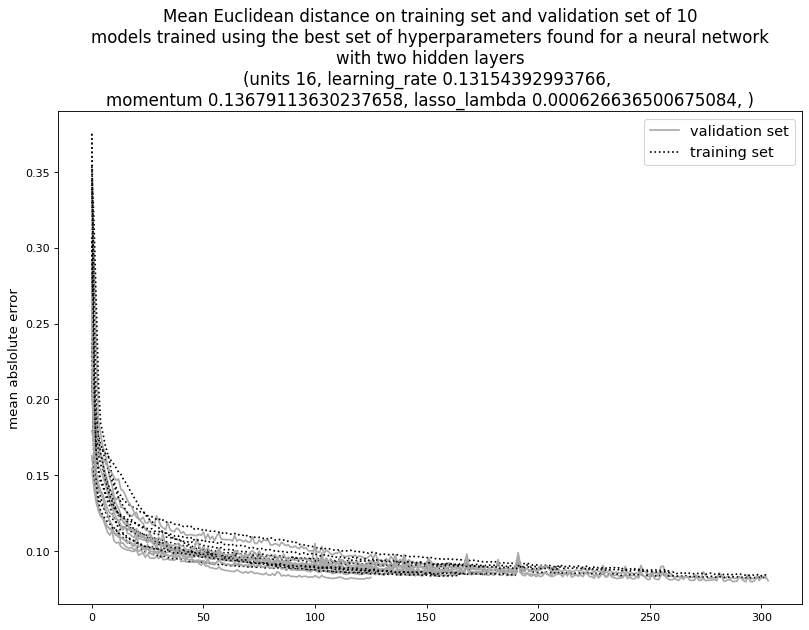

In [42]:
total_hp = 4
labels2 = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "lasso_lambda"]:
    hp_str = best_hp4[0].get(h_param)
    if (h_param == 'units'):
        hp_str *= 2
    labels2 += h_param + " " + str(hp_str) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels2 += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist2[i].history['val_euclidean_distance']
    list_values_tr[i] = hist2[i].history['euclidean_distance']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean Euclidean distance on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")", size=15
)

plt.ylabel("mean abslolute error", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/med_double_layer.png")
plt.show()

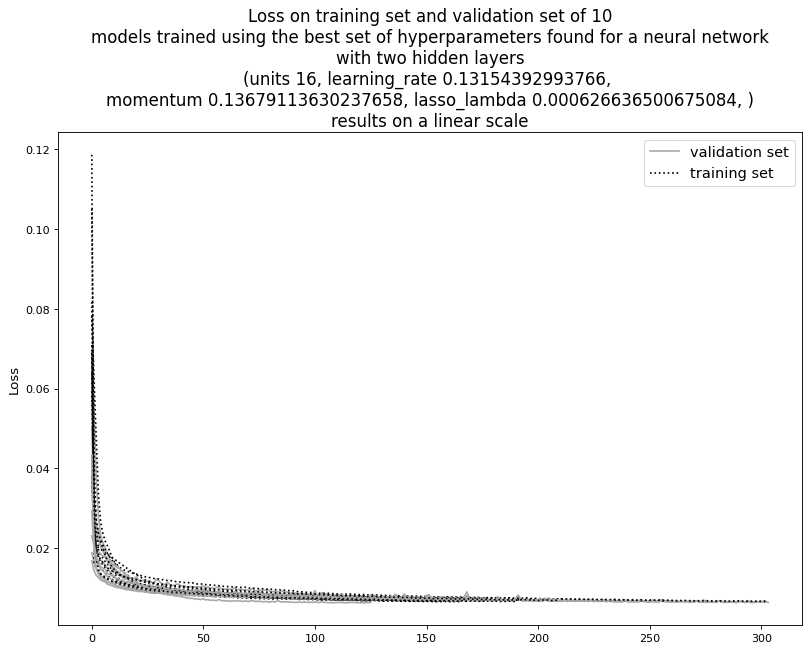

In [43]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist2[i].history['val_loss']
    list_values2_tr[i] = hist2[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer.png")
plt.show()

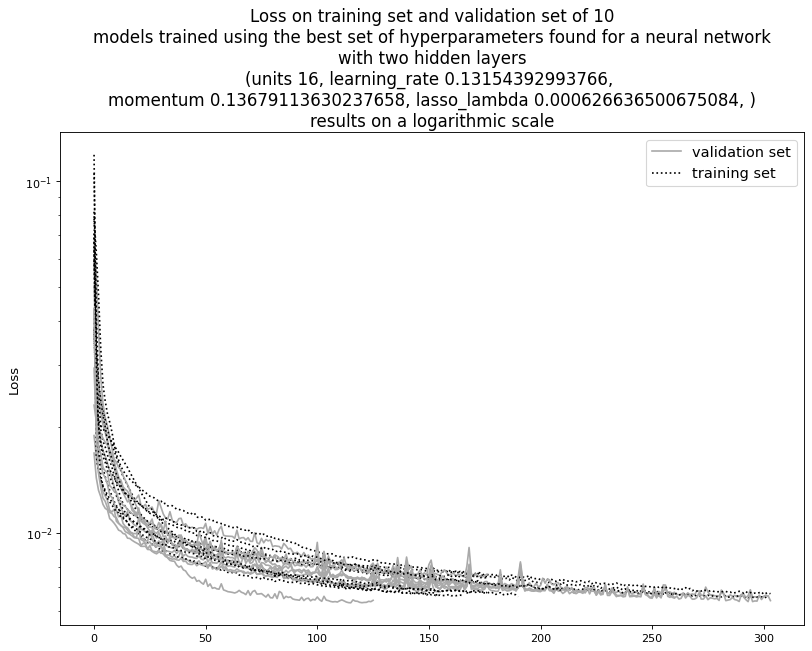

In [44]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer_log.png")
plt.yscale('log')
plt.show()

Let us know birefly compare the final scores reached by the models with two hidden layers and with just one

In [45]:
for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_euclidean_distance']

print("Final score reached by the model with one hidden layer")
for i in range(10):
    a = list_values_val[i][len(list_values_val[i])-1]
    print("model", i, "final mean Euclidean error:", a)
    
predicted_target_ds = models2[0](x_mlcup_ds)


for i in range(n_trials):
    list_values_val[i] = hist2[i].history['val_euclidean_distance']

print("\nFinal score reached by the model with two hidden layers")
for i in range(10):
    a = list_values_val[i][len(list_values_val[i])-1]
    print("model", i, "final mean Euclidean error:", a)
    
predicted_target_ds = models2[0](x_mlcup_ds)

Final score reached by the model with one hidden layer
model 0 final mean Euclidean error: 0.09587271511554718
model 1 final mean Euclidean error: 0.09777761250734329
model 2 final mean Euclidean error: 0.09161899983882904
model 3 final mean Euclidean error: 0.10095526278018951
model 4 final mean Euclidean error: 0.09343699365854263
model 5 final mean Euclidean error: 0.09394041448831558
model 6 final mean Euclidean error: 0.08263389766216278
model 7 final mean Euclidean error: 0.09616141021251678
model 8 final mean Euclidean error: 0.09170392900705338
model 9 final mean Euclidean error: 0.0892801582813263

Final score reached by the model with two hidden layers
model 0 final mean Euclidean error: 0.08345282822847366
model 1 final mean Euclidean error: 0.08430343121290207
model 2 final mean Euclidean error: 0.08196843415498734
model 3 final mean Euclidean error: 0.08018198609352112
model 4 final mean Euclidean error: 0.08502310514450073
model 5 final mean Euclidean error: 0.08242584764

Comparing the final scores reached by the models with one single hidden layer and with two, we found out that the models with two distinct hidden layers performed slightly better. For this reason we retrieved as final model, one among the neural network with two hidden layers. To avoid overfitting, we didn't choose the best model among those with two hidden layers, but the third one (out of 10).

In [66]:
# double hidden layer (retrieve the model with the median error)

rank = 3

for i in range(n_trials):
    list_values_val[i] = hist2[i].history['val_euclidean_distance']

final_values_val = [None]*n_trials
for i in range(n_trials):
    final_values_val[i] = list_values_val[i][len(list_values_val[i]) - 1]

list_scores = [None]*n_trials
for i in range(n_trials):
    list_scores[i] = [final_values_val[i], i]
    
list_scores = sorted(list_scores, key=itemgetter(0))

for i in range(n_trials):
    scr = list_scores[i][0]

index = list_scores[rank][1]

avg_model_val_err = hist2[index].history['val_euclidean_distance']
list_length = len(avg_model_val_err)
final_val_err = avg_model_val_err[list_length - 1]


print(
    "\nThe validation error on the final model for NN with random search is "
      + str(final_val_err) + "\n"
)

avg_model_double = models2[index]
avg_model_double.save("results/ml_cup/nn_RandomSearch/avg_model_double_layer/")


The validation error on the final model for NN with random search is 0.08345282822847366

INFO:tensorflow:Assets written to: results/ml_cup/nn_RandomSearch/avg_model_double_layer/assets


In conclusion, we want to observe the generalization capabilities of our model with respect to the real targets

In [67]:
# predict the targets...

# ... for the whole design set
predicted_target_ds = avg_model_double.predict(x_mlcup_ds)
# ... for the training set 
predicted_target_tr = avg_model_double.predict(x_mlcup_tr)
# ... for the validation set
predicted_target_vl = avg_model_double.predict(x_mlcup_vl)

8/8 [==============================] - 0s 810us/step


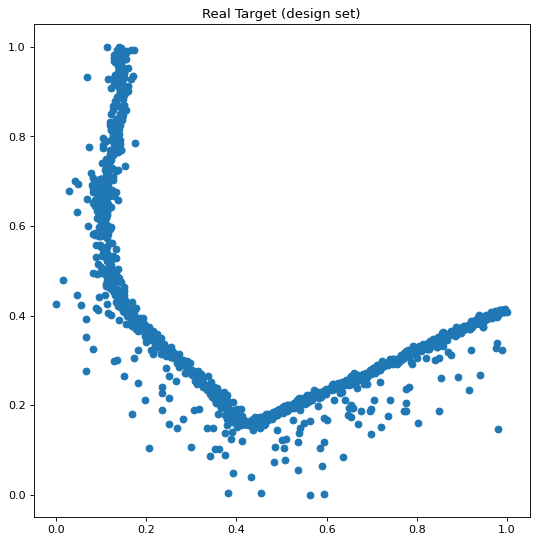

In [68]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(y_mlcup_ds[:, 0], y_mlcup_ds[:, 1])
plt.title("Real Target (design set)")
plt.savefig("./plots/ml_cup/nn_RandomSearch/real_target.png")
plt.show()

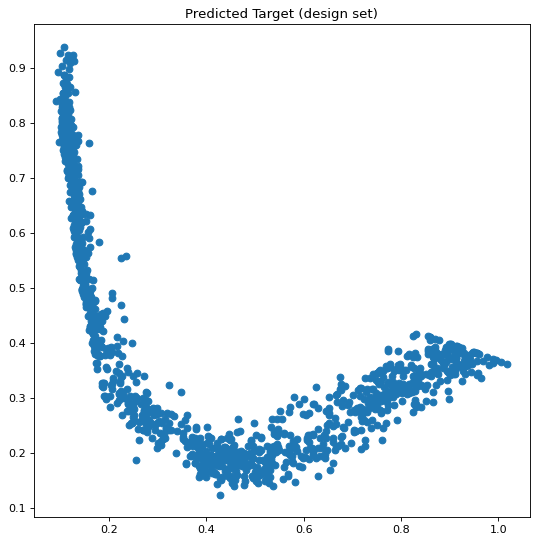

In [69]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_ds[:, 0], predicted_target_ds[:, 1])
plt.title("Predicted Target (design set)")
plt.savefig("./plots/ml_cup/nn_RandomSearch/predicted_target.png")
plt.show()

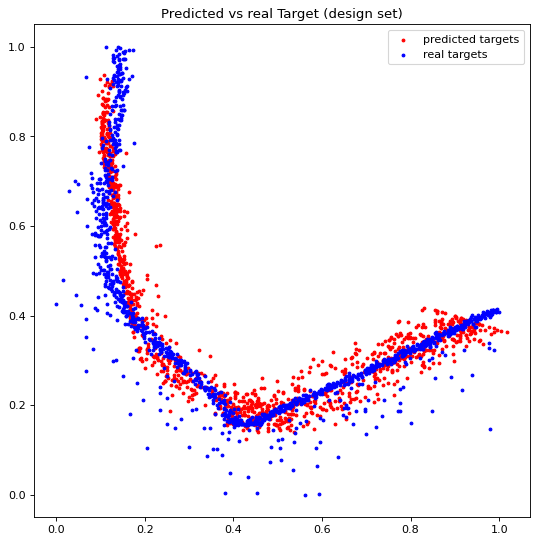

In [70]:
marker_size = 6
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_ds[:, 0], predicted_target_ds[:, 1], s=marker_size, c="red")
plt.scatter(y_mlcup_ds[:, 0], y_mlcup_ds[:, 1], s=marker_size, c="blue")
plt.title("Predicted vs real Target (design set)")

legend = ["predicted targets", "real targets"]
plt.legend(legend)

plt.savefig("./plots/ml_cup/nn_RandomSearch/predicted_vs_real_target.png")
plt.show()


The very last step consists in denormalizing the predicted labels to study which is the final mean Euclidean distance with respect to the real ones. let's start by denormalizing our data

In [72]:
alrDenormalized = False

In [73]:
if (not alrDenormalized):
    # denormalize the training set (real and predicted targets)
    predicted_target_tr = deNormalizer(predicted_target_tr, max_col_value_y, min_col_value_y)
    y_mlcup_tr = deNormalizer(y_mlcup_tr, max_col_value_y, min_col_value_y)
    
    # denormalize the validation set (real and predicted targets)
    predicted_target_vl = deNormalizer(predicted_target_vl, max_col_value_y, min_col_value_y)
    y_mlcup_vl = deNormalizer(y_mlcup_vl, max_col_value_y, min_col_value_y)
    
    alrDenormalized = True

now we can compute the mean Euclidean error

In [74]:
res_tr = compute_mean_euclidean_error(y_mlcup_tr, predicted_target_tr)
res_vl = compute_mean_euclidean_error(y_mlcup_vl, predicted_target_vl)

print("Final mean Euclidean error on the training set: ", res_tr)
print("Final mean Euclidean error on the validation set: ", res_vl)

Final mean Euclidean error on the training set:  1.6750321541383788
Final mean Euclidean error on the validation set:  1.6720859428885648


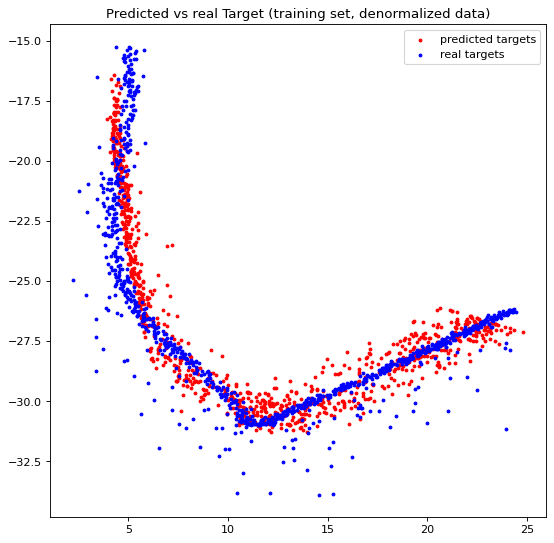

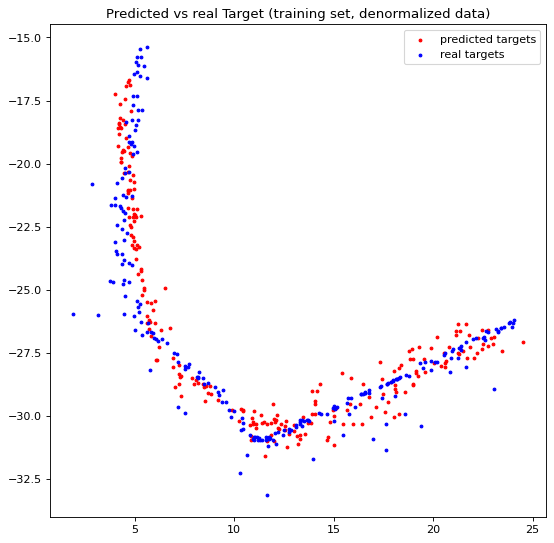

In [75]:
marker_size = 6

# plotting the results for the training set 

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_tr[:, 0], predicted_target_tr[:, 1], s=marker_size, c="red")
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1], s=marker_size, c="blue")
plt.title("Predicted vs real Target (training set, denormalized data)")

legend = ["predicted targets", "real targets"]
plt.legend(legend)

# plotting the results for the validation set 

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_vl[:, 0], predicted_target_vl[:, 1], s=marker_size, c="red")
plt.scatter(y_mlcup_vl[:, 0], y_mlcup_vl[:, 1], s=marker_size, c="blue")
plt.title("Predicted vs real Target (training set, denormalized data)")

legend = ["predicted targets", "real targets"]
plt.legend(legend)

plt.show()